In [1]:
import pandas as pd
import numpy as np

pixel_cols = [f'pixel{i}' for i in range(784)]

# Load Greek (already has 100 per symbol)
greek_df = pd.read_csv("./data/GREEK/greek_letters_500.csv")
greek_df['source'] = 'greek'
greek_df[pixel_cols] = greek_df[pixel_cols] / 255.0
greek_df['label'] = greek_df['label'].astype(str).str.strip()

# Load Math (already has 100 per symbol)
math_df = pd.read_csv("./data/MATH/math_operations_500.csv")
math_df['source'] = 'math'
math_df[pixel_cols] = math_df[pixel_cols] / 255.0
math_df['label'] = math_df['label'].astype(str).str.strip()

# Load EMNIST
emnist_train = pd.read_csv("./data/EMNIST/emnist-byclass-train.csv", header=None)
emnist_test = pd.read_csv("./data/EMNIST/emnist-byclass-test.csv", header=None)

emnist_df = pd.concat([emnist_train, emnist_test], ignore_index=True)
emnist_df.columns = ['label'] + pixel_cols
emnist_df['source'] = 'emnist'
emnist_df[pixel_cols] = emnist_df[pixel_cols] / 255.0

# Map EMNIST numeric labels to characters
mapping_df = pd.read_csv("./data/EMNIST/emnist-byclass-mapping.txt", sep=' ', header=None, names=['label_idx', 'ascii_code'])
mapping_dict = dict(zip(mapping_df['label_idx'], mapping_df['ascii_code'].map(chr)))
emnist_df['label'] = emnist_df['label'].astype(int).map(mapping_dict).astype(str).str.strip()

# Define categories
digits = [str(i) for i in range(10)]
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]
valid_emnist_labels = set(digits + uppercase + lowercase)

# Filter and sample exactly 100 of each from EMNIST
emnist_filtered = emnist_df[emnist_df['label'].isin(valid_emnist_labels)]
emnist_sampled = emnist_filtered.groupby('label').apply(lambda g: g.sample(n=500, random_state=42)).reset_index(drop=True)

# Combine all datasets
combined_df = pd.concat([emnist_sampled, greek_df, math_df], ignore_index=True)

# Ensure all labels are valid and non-empty
combined_df = combined_df[combined_df['label'].notna() & (combined_df['label'] != '')]

# Optional: Balance again if needed (already balanced to 100 each)
# grouped = combined_df.groupby('label').apply(lambda g: g.sample(n=min(len(g), 100), random_state=42)).reset_index(drop=True)

print(f"Final dataset has {combined_df['label'].nunique()} unique labels and {len(combined_df)} total samples.")

/var/folders/bp/k3kx8znx5kz6y45zh5gv4gkc0000gn/T/ipykernel_8954/4206753666.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  emnist_sampled = emnist_filtered.groupby('label').apply(lambda g: g.sample(n=500, random_state=42)).reset_index(drop=True)


Final dataset has 91 unique labels and 45500 total samples.


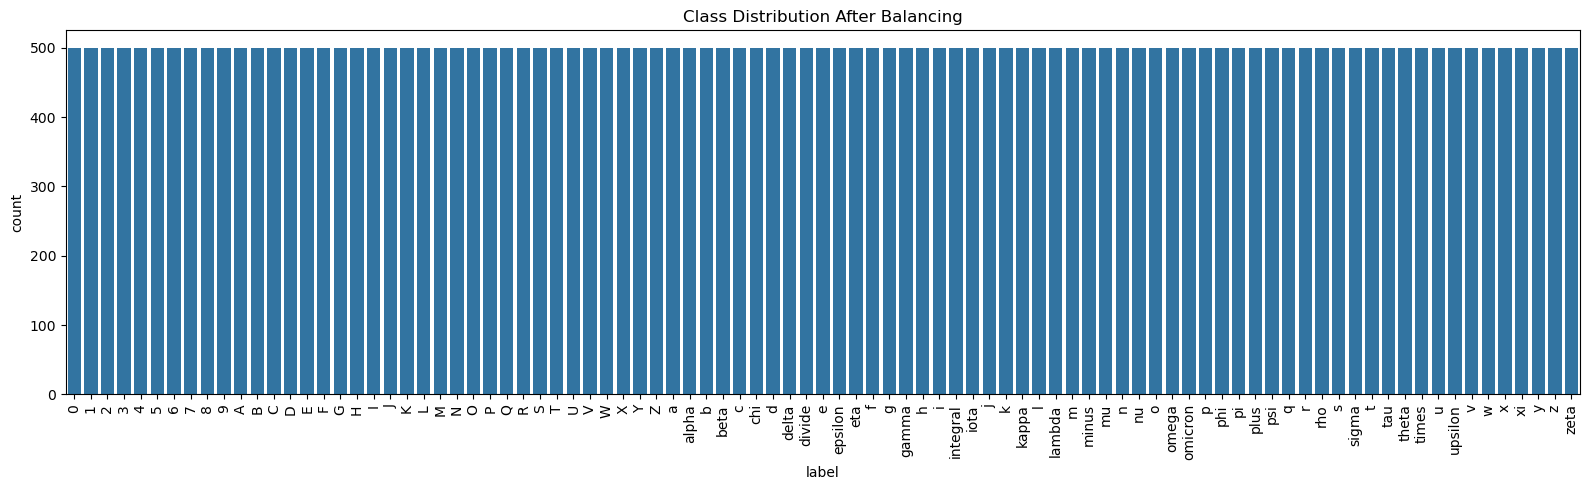

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 5))
sns.countplot(data=combined_df, x='label', order=sorted(combined_df['label'].unique()))
plt.title("Class Distribution After Balancing")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

augment_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])

no_aug_transform = transforms.ToTensor()

class SymbolDataset(Dataset):
    def __init__(self, df, transform=None, label_to_index=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_to_index = label_to_index
        self.index_to_label = {idx: label for label, idx in label_to_index.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = row[pixel_cols].values.reshape(28, 28).astype(np.uint8)
        image = Image.fromarray(image)
        image = self.transform(image) if self.transform else no_aug_transform(image)
        label = self.label_to_index[row['label']]
        return image, label



In [4]:
from sklearn.model_selection import train_test_split

# Centralize label encoding BEFORE dataset split
labels = sorted(combined_df['label'].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

train_df, test_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label'], random_state=42)

train_dataset = SymbolDataset(train_df, transform=augment_transform, label_to_index=label_to_index)
test_dataset = SymbolDataset(test_df, transform=no_aug_transform, label_to_index=label_to_index)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [5]:
import torch.nn as nn

class SymbolCNN(nn.Module):
    def __init__(self, num_classes):
        super(SymbolCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [6]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SymbolCNN(num_classes=len(train_dataset.label_to_index)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: Loss = {total_loss}, Avg Loss = {avg_loss:.4f}")
    
    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"✅ Test Accuracy: {correct / total:.4f}")
    return model


# Run training
trained_model = train_model(model, train_loader, test_loader, epochs=10)


Epoch 1: Loss = 148969.9757232666, Avg Loss = 4.0926
Epoch 2: Loss = 138586.60147094727, Avg Loss = 3.8073
Epoch 3: Loss = 135641.64233398438, Avg Loss = 3.7264
Epoch 4: Loss = 133799.18180847168, Avg Loss = 3.6758
Epoch 5: Loss = 132780.3850517273, Avg Loss = 3.6478
Epoch 6: Loss = 131256.16398239136, Avg Loss = 3.6059
Epoch 7: Loss = 130619.8751487732, Avg Loss = 3.5885
Epoch 8: Loss = 129778.94101333618, Avg Loss = 3.5654
Epoch 9: Loss = 129393.88875961304, Avg Loss = 3.5548
Epoch 10: Loss = 128458.05924987793, Avg Loss = 3.5291
✅ Test Accuracy: 0.0251


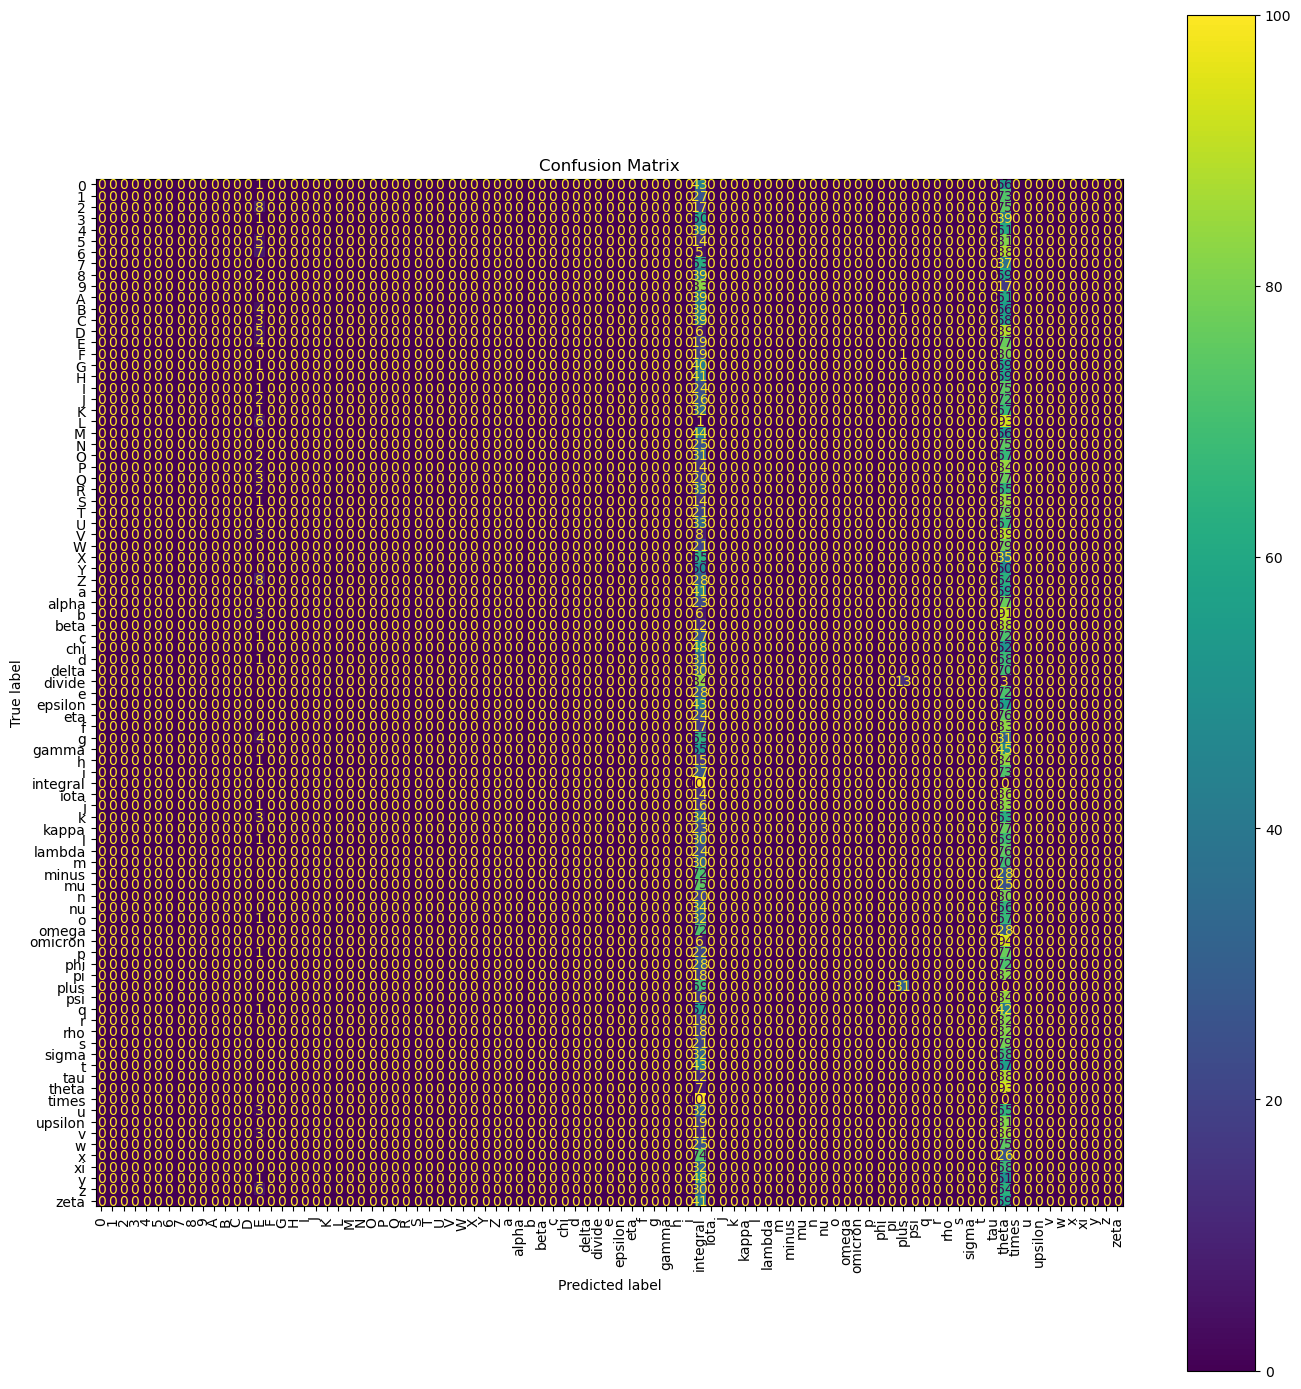

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Collect predictions and labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Decode labels
idx_to_label = train_dataset.index_to_label
labels_str = [idx_to_label[i] for i in range(len(idx_to_label))]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels_str)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_str)
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap='viridis')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [8]:
import pickle
import torch

# Save model
torch.save(model.state_dict(), "trained_symbol_cnn.pth")

# Save label mapping
with open("label_mapping.pkl", "wb") as f:
    pickle.dump(train_dataset.index_to_label, f)


In [9]:
import os
from PIL import Image

# Load model + label mapping
model.load_state_dict(torch.load("trained_symbol_cnn.pth"))
model.eval()
with open("label_mapping.pkl", "rb") as f:
    label_mapping = pickle.load(f)

# Transform for evaluation
eval_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Predict one symbol
def predict_symbol(img_path):
    image = Image.open(img_path).convert("L").rotate(90, expand=True)
    image = eval_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred_idx = torch.argmax(output, dim=1).item()
    return label_mapping[pred_idx]

# Reconstruct equations
from collections import defaultdict
import sympy as sp

symbol_dir = "./output/symbols"
grouped = defaultdict(list)

# Group by page prefix
for f in os.listdir(symbol_dir):
    if f.endswith(".png"):
        page = "_".join(f.split("_")[:-1])
        grouped[page].append(f)

def extract_symbol_index(fname):
    return int(fname.split("_sym")[-1].split(".")[0])

# Predict & evaluate
results = {}

for page, files in grouped.items():
    sorted_files = sorted(files, key=extract_symbol_index)
    expr = "".join([predict_symbol(os.path.join(symbol_dir, f)) for f in sorted_files])
    expr = (expr
        .replace('⋅', '*')
        .replace('π', 'pi')
        .replace('∫', 'integrate'))

    try:
        if any(op in expr for op in ['integrate', 'pi', 'sin', 'cos']):
            x = sp.Symbol('x')
            result = eval("sp." + expr)
        else:
            result = eval(expr)
        results[page] = (expr, result)
    except Exception as e:
        results[page] = (expr, f"Error: {e}")

# Display
for page, (expr, value) in results.items():
    print(f"{page}: {expr} = {value}")


integration_page_0: V2VzZVVZVH2 = Error: name 'V2VzZVVZVH2' is not defined
division_page_0: VVuQZR = Error: name 'VVuQZR' is not defined
multiplication_page_0: VQ2 = Error: name 'VQ2' is not defined
subtraction_page_0: VVZV = Error: name 'VVZV' is not defined
addition_page_0: VAE = Error: name 'VAE' is not defined
